<a href="https://colab.research.google.com/github/aCStandke/ReinforcementLearning/blob/main/Experimental_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Importing the OpenAI Gym environment for Super Mario Bros

That plays on the Nintendo entertainment System(NES) through a nes-py emulator.

By default, gym_super_mario_bros 
environments use the full NES action space of 256 discrete actions. To contstrain this, gym_super_mario_bros.actions provides three actions lists (RIGHT_ONLY, SIMPLE_MOVEMENT, and COMPLEX_MOVEMENT) for the nes_py.wrappers.JoypadSpace wrapper. See gym_super_mario_bros/actions.py for a breakdown of the legal actions in each of these three lists.



---


Citation: 
@misc{gym-super-mario-bros,
  author = {Christian Kauten},
  howpublished = {GitHub},
  title = {{S}uper {M}ario {B}ros for {O}pen{AI} {G}ym},
  URL = {https://github.com/Kautenja/gym-super-mario-bros},
  year = {2018},
}



In [1]:
!python3 -m pip install gym-super-mario-bros==7.3.0
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

from pyvirtualdisplay import Display

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.


In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

# TRAIN A MARIO-PLAYING RL AGENT
Orinial Authors: Yuansong Feng, Suraj Subramanian, Howard Wang, Steven Guo.

This was a tutorial made from the orginal authours that walks through the fundamentals of Deep Reinforcement Learning.

1.   See https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html for more details regarding implementation and results



In [3]:
# Installing the required libraries
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy
from IPython import display as ipythondisplay
import time, datetime
import pickle
from tqdm import tqdm
import glob
import io
import base64
import heapq
from IPython.display import HTML



# Installing Gym an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
from gym.wrappers import Monitor

# Installing NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Installing Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY


# Functions to Display Mario play the game:
These functions use the display backend of the python virtural environment to record mario in the enviorment by wrapping Mario's environment in the function wrap_env() which uses OpenAI's gym Monitor wrapper to record Mario in the env when render is called. The fuction show_video() displays the video using ipythondisplay.display in HTML form using the <video> tag on the colab server. 



*   See this notebook by  Jeff Heaton:  https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj for more information on rendering Open AI games



In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Initialize the Mario enviornment

The mario environment is intialized using the method make(). 



In [5]:
# Initialize Super Mario environment
env = wrap_env(gym_super_mario_bros.make("SuperMarioBros-1-1-v0"))

# Preprocessing the Environment

Since alot of the environmental information is not necessary(ie., color), Wrappers are used to preprocess the environment data before sending it to the agent/Mario. 



1.   **SkipFrame Class:**
  *   This wrapper inherits from the gym.Wrapper and implements the step() function. Because consecutive frames don’t vary much, we can skip n-intermediate frames without losing much information. The n-th frame aggregates rewards accumulated over each skipped frame.

2.   **FrameStack Class:**
  *   Is a wrapper that allows us to squash consecutive frames of the environment into a single observation point to feed to our learning model. This way, we can identify if Mario was landing or jumping based on the direction of his movement in the previous several frames. 

3.   **GrayScaleObservation and ResizeObservation Classes**
  *   These wrappers inherit from the gym.ObservationWrapper to first transform an RGB image to grayscale so that one color channel is used. Then the image is downsampled for each observation into a square image

4.  **JoypadSpace**
 *   Because the orginal Mario action space consists of 256 discrete actions, the number of actions that Mario can take is limited by setting the JoypadSpace wrapper to RIGHT_ONLY





In [6]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = []
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward.append(reward)
            if done:
                break
        return obs, reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)
# Using the RIGHT_ONLY action list for Mario in the environment
env = JoypadSpace(env, RIGHT_ONLY)

# Creating the Mario Agent

The Mario Agent should be able to do the following things:

1.   **ACT:** Mario should be able to take the most optimal action policy based on the current state of the environment
2.   **Remember:** Mario should be able to remember his past actions, to update his action policy. In this case Experience/Memory for Mario =(current state, current action, reward, next state). This is implemented through caching and later recalling his experiences
3.   **Learn:** Mario should learn a better action policy overtime 



---

# Act

For any given state, Mario can choose to do the most optimal action(called exploit) or a random action(called explore). When Mario chooses to randomly explore this chance is determined by self.exploration_rate; however, when Mario chooses to exploit, Mario relies on MarioNet, which is a DDQN algorithm to get the most optimal action.

An additional pre-trained agrument was added to test the model and/or incrementaly improve the model. This section loads the previous model's weights and previous exploration rate


*   See https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/ for more information regarding pretraining the model 




In [7]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir
        self.pretrained = pretrained
        self.count_explore = 0
        self.count_exploit = 0
        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action when doing exploit
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        
        if self.use_cuda:
           self.net = self.net.to(device="cuda")
        if self.pretrained:
           self.exploration_rate = torch.load('exploration_rate.pth')
           self.net.load_state_dict(torch.load("model.pth")) 
        self.exploration_rate = 1
        self.exploration_rate_decay =  0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0
        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def get_exploration_rate(self):
      return self.exploration_rate

    def act(self, state):
        # Given a state, shoose an epsilon-greedy action
        # and update value of step

        # Inputs:
        # state: A single observation of the current state, dim
        # is (state_dim)
        # Outputs:
        # action: an int representing with action Mario will take

        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx


# Mario's Memory implemented as prioritized experience replay

💛

1.   **Cache function:** Each time Mario performs an action, he stores the experience to his memory in the priority class. His experience includes the current state, action performed, reward from the action, the next state, and whether the game is done, and a priorty value for priority sampeling.
2.   **Recall function:** Mario randomly samples a batch of experiences from his memory. Instead of uniform random sampling, I decided to try stochastic sampling after reading the following article 
[PRIORITIZED EXPERIENCE REPLAY](https://arxiv.org/pdf/1511.05952v1.pdf). Namely I tried to implement the following portion of the pseudocode from the paper: 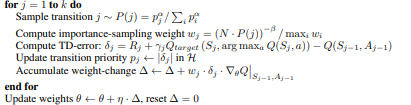

 

---

After trying a simple Priority based data structure for the storing of the memory and priortized sampeling as detailed in the following code snippet: 


```
class Priority(object):
  def __init__(self, epislon):
    self.priority = []
    self.epislon = epislon
    self.alpha = 0.6
    self.beta = 0.4
    self.temp = deque(maxlen=32)
    self.len = 0

  def insert(self,state, next_state, action, reward, done, priority):
    p = np.absolute(priority) + self.epislon
    self.priority.append((p, state, next_state, action, reward, done))
    self.priority.sort(key=priorityelement, reverse=True)

  def update(self, old, new):
    p=np.absolute(new)
    for i in range(len(self.priority)):
      if self.priority[i][0] == old:
        self.priority[i][0] = new

  def get_sample(self, batch):
    numerator = []
    denominator = []
    for p, state, next_state, action, reward, done in self.priority[:batch]:
      numerator.append(p**self.alpha)
      self.temp.append((state, next_state, action, reward, done))
    for p in self.priority:
      denominator.append(p[0]**self.alpha)
      self.len += 1
    top = np.array(numerator)
    bottom = np.sum(np.array(denominator))
    # sample transition j probability distribution
    j = top/bottom
    batch = random.choices(self.temp, weights=j, k=batch)
    # computing importance sampiling weight
    N = 1/self.len
    P = 1/j
    weight_i = (N*P)**self.beta
    weight_j = 1/max(weight_i)
    return batch, weight_j
```

I was getting nothing but errors and wrong results! In the end, I used openAI's implementation as found here: [openAi](https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py)

---


In [8]:
# Implementation taken directly from openAI

import operator

class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]

class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""
        return super(MinSegmentTree, self).reduce(start, end)

###################################################################################################################################################

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(obs_t)
            actions.append(action)
            rewards.append(reward)
            obses_tp1.append(obs_tp1)
            dones.append(done)
        return obses_t, actions, rewards, obses_tp1, dones

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha >= 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha
    
    # sampling using the first variant of paper named
    # proportional prioritizaion i.e. not using rank-based
    # prioritization
    def _sample_proportional(self, batch_size):
        res = []
        p_total = self._it_sum.sum(0, len(self._storage) - 1)
        every_range_len = p_total / batch_size
        for i in range(batch_size):
            mass = random.random() * every_range_len + i * every_range_len
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes) 
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

In [9]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        super().__init__(state_dim, action_dim, save_dir, pretrained)
        self.batch_size = 32
        self._priorityReplay = PrioritizedReplayBuffer(30000, alpha=0.6) 
  
    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)
        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()
        if self.use_cuda:
          state = torch.tensor(state).cuda()
          next_state = torch.tensor(next_state).cuda()
          action = torch.tensor([action]).cuda()
          reward = torch.tensor([reward]).cuda()
          done = torch.tensor([done]).cuda()
        else:
          state = torch.tensor(state)
          next_state = torch.tensor(next_state)
          action = torch.tensor([action])
          reward = torch.tensor([reward])
          done = torch.tensor([done])
        
        # obs_t, action, reward, obs_tp1, done
        self._priorityReplay.add(state, action, reward, next_state, done)
  
    def recall(self):
        """
        Retrieve a batch of experiences from memory
        batch_size, beta
        state, next_state, action, reward, done, weight
        """
        state,  action, reward, next_state, done, weight, idxes = self._priorityReplay.sample(self.batch_size, 0.4)
        return state, next_state, action, reward, done, weight, idxes

    def update(self, idxes, priorities):
      self._priorityReplay.update(idxes, priorities)


# Learning

Mario's Action policy for solving sequential decision problems (ie., the machine brain, lol) is the DDQN algorithm as detailed in https://arxiv.org/pdf/1509.06461.pdf[1]


---
# Double DQN Algorithm
The idea of Double Q-learning is to reduce overestimations
by decomposing the max operation in the target into action
selection and action evaluation[1]. The algorithm evaluates the greedy policy according to the online network and uses the target network to estimate its value[1]. 

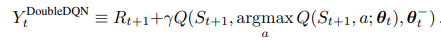

The weights of the second network contain the weights of the target network ***Θₜ-***for the evaluation of the current greedy policy. The update to the target network stays unchanged from
DQN, and remains a periodic copy of the online network[1].









In [10]:
class MarioNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim
       

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

# TD Estimate & TD Target

Two values are involved in learning:
**TD Estimate** - the predicted optimal 𝑸* for a given state *s*

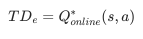

**TD Target** - aggregation of current reward and the estimated 𝑸* in the next state *s'* 


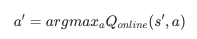

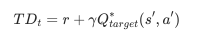

In [11]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        super().__init__(state_dim, action_dim, save_dir, pretrained)
        self.gamma = 0.9
 
    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

# Updating Double DQN Model 

As Mario samples inputs from his replay buffer, we compute *TDₜ* and *TDₑ* and backpropagate this loss down Qₒₗᵢₙₑ to update its parameters *θₒₗᵢₙₑ* (α is the learning rate)  
​
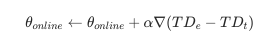

theta_target weights does not get updated during backpropogation, instead rather weights from online are assigned to the weights to the target
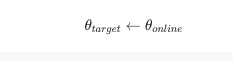


In [12]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        super().__init__(state_dim, action_dim, save_dir, pretrained)
        self.loss_fn = torch.nn.SmoothL1Loss()
        self.delta = 0
    
    # accumulate weight changes
    def accumulate_weight_chage(self, weight, td_error, Q_gradient):
      self.delta += weight * td_error * Q_gradient
      return self.delta

    def update_Q_online(self, td_estimate, td_target, weight, Q_gradient):
        #computing the TD-error:
        loss = self.loss_fn(td_estimate, td_target)
        delta = self.accumulate_weight_chage(weight, td_estimate, loss.item())
        lr = 0.0000625*delta
        optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        self.delta = 0
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

# Training the Mario Agent!

Mario was trained for 10,000 episodes on the GPU and the Double DQN model weights were saved along with the exploration rate, and Mario's memory, which is a deque collecion of max lenghth 30000 of tuples containing:


1.   The state that Mario remembers when deciding on an action (ie., saved as LazyFrame object of four tensors)
2.   The next_state that Mario remembers after taking the ation (ie., saved as LazyFrame object of four tensors)
3.   The action Mario took from the action space (ie., int)
4.   The reward Mario recieved for his action (ie., float)
5.   And whether this combination of state, action, nextstate, and reward led to ending the game (i.e., done state)


---
# Key HyperParmaters: ✴

1. **self.burnin** : the count of frames (experiences) to add to memory/cache before starting training.
2. **self.learn_every** : the count of frames (expperiences) to add to memory/cace before updating the weights of the online DQN network
3. **self.sync_every** : indicates how frequently we sync model weights from the online DQN network to the target DQN network (i.e.how many frames in between syncing)








In [13]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, pretrained):
        super().__init__(state_dim, action_dim, save_dir, pretrained)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()
        
        if self.curr_step < self.burnin:
            return

        if self.curr_step % self.learn_every != 0:
            return

        # Sample from memory
        state, next_state, action, reward, done, weight, idxes = self.recall()
        td_est = []
        td_tgt = []
        for idx in idxes:   
          # Get TD Estimate
          td_est.append(self.td_estimate(state[idx], action[idx]))
          # Get TD Target
          td_tgt.append(self.td_target(reward[idx], next_state[idx], done[idx]))
          self.update(idx, abs(td_tgt[idx]))
          # Backpropagate loss through Q_online
        self.update_Q_online(td_est, td_tgt, weight)

In [14]:
def run(training_mode, pretrained, num_episodes=1):
  use_cuda = torch.cuda.is_available()
  print(f"Using CUDA: {use_cuda}")
  print()

  save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
  save_dir.mkdir(parents=True)
  mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir, pretrained=pretrained)
  

  total_rewards =[]
  for e in tqdm(range(num_episodes)):
    state = env.reset()
    total_reward = 0
    while True:
      # Run agent on the state
      action = mario.act(state)
       # Agent performs action in environment
      next_state, reward, done, info = env.step(action)
      mario.cache(state, next_state, action, reward, done)
      # Play the game!
      env.render()
      total_reward += reward
      if training_mode:
        # Learn
        mario.learn()
      # Update state
      state = next_state
      # Check if end of game
      if done or info["flag_get"]:
        break

    total_rewards.append(total_reward)
    if e != 0 and e % 10 == 0:
      print("Episode {} score = {}, average score = {}".format(e + 1, total_rewards[-1], np.mean(total_rewards)))

    # print("Episode {} score = {}, average score = {}".format(e + 1, total_rewards[-1], np.mean(total_rewards)))
  
  # if training_mode:
  #   #saving model weights
  #   torch.save(mario.net.state_dict(), "model.pth")
  env.close()
  #show_video()


In [15]:
# Testing Mario and gathering video of his performance over one episode
run(training_mode=True, pretrained=False, num_episodes=100)

Using CUDA: False



  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256
  1%|          | 1/100 [00:04<07:56,  4.81s/it]/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256
  8%|▊         | 8/100 [00:25<05:14,  3.42s/it]/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256
 11%|█         | 11/100 [00:28<02:32,  1.71s/it]

Episode 11 score = 50, average score = 144.1818181818182


 21%|██        | 21/100 [01:13<05:45,  4.38s/it]

Episode 21 score = 136, average score = 165.8095238095238


 27%|██▋       | 27/100 [01:34<03:19,  2.73s/it]/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256
 31%|███       | 31/100 [01:43<03:10,  2.76s/it]

Episode 31 score = 174, average score = 154.48387096774192


 38%|███▊      | 38/100 [02:18<03:46,  3.65s/it]


IndexError: ignored